# classiq

In [1]:
%pip install qiskit
%pip install classiq
%pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 9.9 MB/s 
     |████████████████████████████████| 18.0 MB 26.8 MB/s 
     |████████████████████████████████| 240 kB 68.4 MB/s 
     |████████████████████████████████| 112 kB 67.6 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 1.6 MB 70.8 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 63.0 MB/s 
     |████████████████████████████████| 4.1 MB 68.5 MB/s 
     |████████████████████████████████| 112 kB 92.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.1-py3-none-any.whl size=12067 sha256=6152e55025b81a3a4199fdee9b06792317416be50bd76f13974d49047b474972
  Stored in directory: /root/.cache/pip/wheels/1c/3c/a3/bf8c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nest_asyncio
nest_asyncio.apply()
import classiq

classiq.authenticate()

Your user code: QLHG-CSZM
If a browser doesn't automatically open, please visit the url: https://classiq.eu.auth0.com/activate?user_code=QLHG-CSZM


In [3]:
from classiq import ModelDesigner, Executor
from classiq.builtin_functions import UCC, HartreeFock

from classiq.interface.chemistry.molecule import Molecule
from classiq.interface.chemistry.ground_state_problem import GroundStateProblem
from classiq.interface.backend.backend_preferences import (
    IBMBackendPreferences,
    IBMBackendProvider,
)
from classiq.interface.executor.execution_preferences import ExecutionPreferences, OptimizerPreferences
from classiq.interface.executor.hamiltonian_minimization_problem import HamiltonianMinimizationProblem
from classiq.interface.executor.quantum_instruction_set import QuantumInstructionSet
from classiq.interface.executor.quantum_program import QuantumProgram
from classiq.interface.chemistry.operator import PauliOperator
from classiq import ModelDesigner
from classiq.builtin_functions import HardwareEfficientAnsatz

### preparing the hamiltonian for n quibts (Ising model)

In [4]:
import numpy as np
from qiskit.opflow import Z, I

def multiply_ising_models(ham1, ham2, coef1, coef2):
  final_sigma = ""
  final_coef = 0
  for i in range(len(ham1)):
      sigma1 = ham1[i]
      sigma2 = ham2[i]
      if (sigma1 == 'Z' and sigma2 == 'Z'):
        final_sigma += 'I'
      elif (sigma1 == 'I' and sigma2 == 'Z'):
        final_sigma += 'Z'
      elif (sigma1 == 'Z' and sigma2 == 'I'):
        final_sigma += 'Z'
      else:
        final_sigma += 'I'
  return (final_sigma,coef1*coef2)


def create_general_hamiltonian_classiq(S):
  num_qubits = len(S)
  operator = []
  sigmas_list = []
  for qubit in range(num_qubits):
    if qubit == 0:
       sigma = "Z"
    else:
       sigma = "I"
    for i in range(1,num_qubits):
      if i == qubit:
        sigma = sigma + "Z"
      else:
        sigma = sigma + "I"
    sigmas_list.append((sigma,S[qubit]))

  for i in range(len(sigmas_list)):
    for j in range(len(sigmas_list)):
      sigma = multiply_ising_models(sigmas_list[i][0], sigmas_list[j][0], sigmas_list[i][1], sigmas_list[j][1])
      operator.append(sigma)
  return operator 


## Prepare simulator

In [5]:
def define_simulator(simulator_name):
    if(simulator_name == "qasm" or simulator_name == "QASM"):
      curr_simulator = "qasm_simulator"
    else:
      curr_simulator = "aer_simulator_statevector"
    return curr_simulator

In [6]:
def define_optimizer(optimizer_name):
    if(optimizer_name == "cobyla" or optimizer_name == "COBYLA"):
      curr_optimizer = "COBYLA"
    else:
      curr_optimizer = "L_BFGS_B"
    return curr_optimizer

In [7]:
def prepare_simulator_classiq(curr_simulator, curr_optimizer,num_of_qubits=2, anzatz_first_gate = "x",anzatz_second_gate = "ry"):
    NUM_QUBITS = num_of_qubits
    FULLY_CONNECTED_MESH = []
    for i in range(num_of_qubits-1):
        FULLY_CONNECTED_MESH.append([i,i+1])
    hwea_params = HardwareEfficientAnsatz(
        num_qubits=NUM_QUBITS,
        connectivity_map=FULLY_CONNECTED_MESH,
        one_qubit_gates=[anzatz_first_gate, anzatz_second_gate],
        two_qubit_gates="cx",
        reps=3,
    )

    model_designer = ModelDesigner()
    model_designer.HardwareEfficientAnsatz(params=hwea_params)
    circuit = model_designer.synthesize()
    #circuit.show()
    #circuit.draw()
    circuit_qasm = circuit.qasm
    optimizer_preferences = OptimizerPreferences(
        max_iteration=60,
        name = curr_optimizer
    )

    ibm_provider = IBMBackendProvider(
        "insert your data"
    )

    backend_preferences = IBMBackendPreferences(
        backend_name=curr_simulator,
        access_token="insert your data",
        provider=ibm_provider,
    )

    num_shots = 8192

    execution_preferences = ExecutionPreferences(
        num_shots=num_shots,
        backend_preferences=backend_preferences,
        optimizer_preferences=optimizer_preferences
    )
    return execution_preferences, circuit_qasm

## compute minimal eigenvalue

In [127]:
def minimum_eigenvalue_by_vqe(H):
  hamiltonian_problem = HamiltonianMinimizationProblem(
      ansatz=QuantumProgram(code=circuit_qasm, syntax=QuantumInstructionSet.QASM),
      hamiltonian=H
  )
  result = Executor(
      preferences=execution_preferences
  ).execute_hamiltonian_minimization(hamiltonian_problem)
  print("minimal eigenvalue: ", format(result.energy,".3f"))
  return result.energy

## define parameters

In [128]:
avg_array_solvable = []
avg_array_unsolvable = []
avg = 0.0
sum = 0
entanglement = "linear"

# solvable sets of 2 quibts

In [129]:
s1 = [1,1]
s2 = [2,2]
s3 = [24,24]
s4 = [0,0]

In [130]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.000


In [131]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.000


In [132]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.135


In [133]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.000


In [134]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 2 quibts

In [135]:
s1 = [0,1]
s2 = [1,2]
s3 = [2,24]
s4 = [23,25]

In [136]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) -1

minimal eigenvalue:  1.000


In [137]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) -1

minimal eigenvalue:  1.000


In [138]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) - 484

minimal eigenvalue:  484.058


In [139]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) - 4

minimal eigenvalue:  4.200


In [140]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 3 quibts

In [141]:
s1 = [0,1,1]
s2 = [1,3,2]
s3 = [7,4,3]
s4 = [40,20,60]

In [142]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.047


In [143]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  0.385


In [144]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  12.210


In [145]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  233.980


In [146]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 3 quibts

In [147]:
s1 = [1,1,1]
s2 = [1,4,6]
s3 = [13,1,11]
s4 = [21,56,87]

In [148]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) - 1

minimal eigenvalue:  1.024


In [149]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) -1

minimal eigenvalue:  6.532


In [150]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) -1

minimal eigenvalue:  10.364


In [151]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator) -100

minimal eigenvalue:  1859.801


In [152]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 4 quibts

In [153]:
s1 = [1,6,2,3]
s2 = [8,2,4,2]
s3 = [14,7,3,4]
s4 = [7,1,5,3]

In [154]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  6.928


In [155]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  26.488


In [156]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  56.462


In [157]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  18.849


In [158]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 4 quibts

In [159]:
s1 = [1,5,3,2]
s2 = [8,6,4,5]
s3 = [14,7,5,4]
s4 = [7,3,4,3]

In [160]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz") 
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  5.614


In [161]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-9

minimal eigenvalue:  29.255


In [162]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-4

minimal eigenvalue:  67.780


In [163]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-9

minimal eigenvalue:  21.721


In [164]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 5 quibts

In [165]:
s1 = [2,3,5,4,6]
s2 = [5,3,5,10,3]
s3 = [4,7,3,7,7]
s4 = [1,5,3,4,5]

In [166]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  19.327


In [167]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  15.700


In [168]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  33.066


In [169]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  19.517


In [170]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 5 quibts

In [171]:
s1 = [4,3,5,5,6]
s2 = [5,4,4,10,2]
s3 = [4,7,3,13,2]
s4 = [2,4,4,4,5]

In [172]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  22.580


In [173]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  31.873


In [174]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  42.704


In [175]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  14.699


In [176]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 6 quibts

In [177]:
s1 = [4,5,3,4,4,4]
s2 = [7,5,7,9,9,1]
s3 = [8,1,2,5,1,5]
s4 = [4,7,4,5,5,5]

In [178]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  20.507


In [179]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  77.881


In [180]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  36.759


In [181]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  41.878


In [182]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 6 quibts

In [183]:
s1 = [3,6,3,4,5,4]
s2 = [6,5,8,9,8,1]
s3 = [7,2,2,6,2,4]
s4 = [6,7,2,5,4,5]

In [184]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  43.699


In [185]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  74.760


In [186]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  42.909


In [187]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  58.531


In [188]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 7 quibts

In [189]:
s1 = [4,5,4,5,4,8,6]
s2 = [7,3,7,4,4,4,5]
s3 = [8,1,2,5,6,6,4]
s4 = [5,3,4,5,12,4,1]

In [190]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  20.224


In [191]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  60.861


In [192]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  69.341


In [193]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  49.233


In [194]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 7 quibts

In [195]:
s1 = [0,0,0,0,0,0,2]
s2 = [1,2,3,4,10,1,0]
s3 = [7,4,7,4,11,11,1]
s4 = [5,3,4,6,16,1,2]

In [196]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-4

minimal eigenvalue:  4.000


In [197]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  54.119


In [198]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  42.210


In [199]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  133.114


In [200]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 8 quibts

In [201]:
s1 = [1,0,0,0,0,0,2,1]
s2 = [1,2,3,4,10,0,0,0]
s3 = [5,6,7,8,11,11,1,3]
s4 = [5,3,4,2,10,1,1,2]

In [202]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  3.191


In [203]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  43.025


In [204]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  84.463


In [205]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  81.150


In [206]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 8 quibts

In [207]:
s1 = [1,0,0,0,1,0,2,1]
s2 = [1,2,3,4,11,0,2,2]
s3 = [5,9,4,8,10,11,1,3]
s4 = [6,2,4,2,9,1,1,2]

In [208]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  3.853


In [209]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  51.287


In [210]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  160.435


In [211]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  74.196


In [212]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 9 quibts

In [213]:
s1 = [1,6,2,0,1,2,6,2,0]
s2 = [4,1,0,6,4,6,4,3,2]
s3 = [2,1,0,4,5,7,3,1,1]
s4 = [3,9,1,8,3,12,4,8,0]

In [214]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  11.473


In [215]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  36.800


In [216]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  26.680


In [217]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  146.367


In [218]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 9 quibts

In [219]:
s1 = [2,8,4,11,3,7,5,7,0]
s2 = [2,0,6,3,5,1,4,1,3]
s3 = [3,2,1,2,4,6,5,3,5]
s4 = [2,5,2,0,1,2,6,3,0]

In [220]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  133.570


In [221]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  37.928


In [222]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  41.625


In [223]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  15.770


In [224]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# solvable sets of 10 quibts

In [225]:
s1 = [8,2,5,1,0,2,4,3,2,5]
s2 = [6,8,4,2,9,5,5,9,6,4]
s3 = [5,8,1,3,2,6,4,3,3,3]
s4 = [6,4,3,0,8,10,6,4,1,0]

In [226]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  80.022


In [227]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  163.424


In [228]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  122.259


In [229]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)

minimal eigenvalue:  95.024


In [230]:
avg = sum / 4.0
avg_array_solvable.append(avg)

# unsolvable sets of 10 quibts

In [231]:
s1 = [7,3,2,4,0,2,4,3,1,5]
s2 = [5,9,4,2,9,5,5,8,6,4]
s3 = [6,7,1,3,2,6,4,3,2,3]
s4 = [5,5,2,1,8,9,6,4,1,0]

In [232]:
sum = 0
partitioningProblem = create_general_hamiltonian_classiq(s1)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s1) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  80.316


In [233]:
partitioningProblem = create_general_hamiltonian_classiq(s2)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s2) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  179.947


In [234]:
partitioningProblem = create_general_hamiltonian_classiq(s3)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s3) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  111.006


In [235]:
partitioningProblem = create_general_hamiltonian_classiq(s4)
operator= PauliOperator(pauli_list=partitioningProblem)
curr_simulator = define_simulator("aer_statevector")
curr_optimizer = define_optimizer("cobyla")
execution_preferences, circuit_qasm = prepare_simulator_classiq(curr_simulator, curr_optimizer,len(s4) , "ry","rz")
sum += minimum_eigenvalue_by_vqe(operator)-1

minimal eigenvalue:  85.715


In [236]:
avg = sum / 4.0
avg_array_unsolvable.append(avg)

# create the graphs

# solvable problems deviation from the desired result

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

range(2, 11)
[0.0337991510776216, 61.65532472241821, 27.18183839318683, 21.90249497620745, 44.25649346477821, 49.91507435821412, 52.957187130102604, 55.330019261669904, 115.18224915732887]


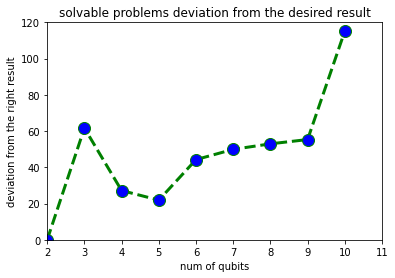

In [242]:


import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_solvable
# corresponding x axis values
x = range(2,11)

print(x)
print(y)
# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(0,120)
plt.xlim(2,11)
  
# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('solvable problems deviation from the desired result')
  
# function to show the plot
plt.show()


# unsolvable problems deviation from the desired result

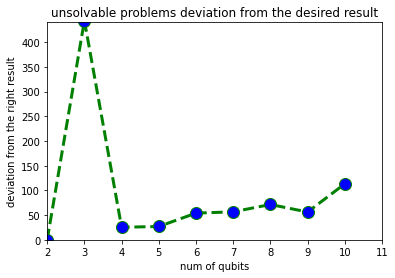

range(2, 11)
[0.06446237582438852, 443.68013629034897, 25.3425874674068, 26.96399172536994, 53.97460349630358, 56.610739577823175, 71.44264579117268, 56.22299167857564, 113.24571230074744]


In [245]:
import matplotlib.pyplot as plt
  
# y axis values
y = avg_array_unsolvable
# corresponding x axis values
x = range(2,11)
  
# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(0,440)
plt.xlim(2,11)
  
# naming the x axis
plt.xlabel('num of qubits')
# naming the y axis
plt.ylabel('deviation from the right result')
  
# giving a title to my graph
plt.title('unsolvable problems deviation from the desired result')
  
# function to show the plot
plt.show()
print(x)
print(y)